Привет! Меня зовут Илья и это мое решение тестового задания , спасибо за возможность его выполнения !

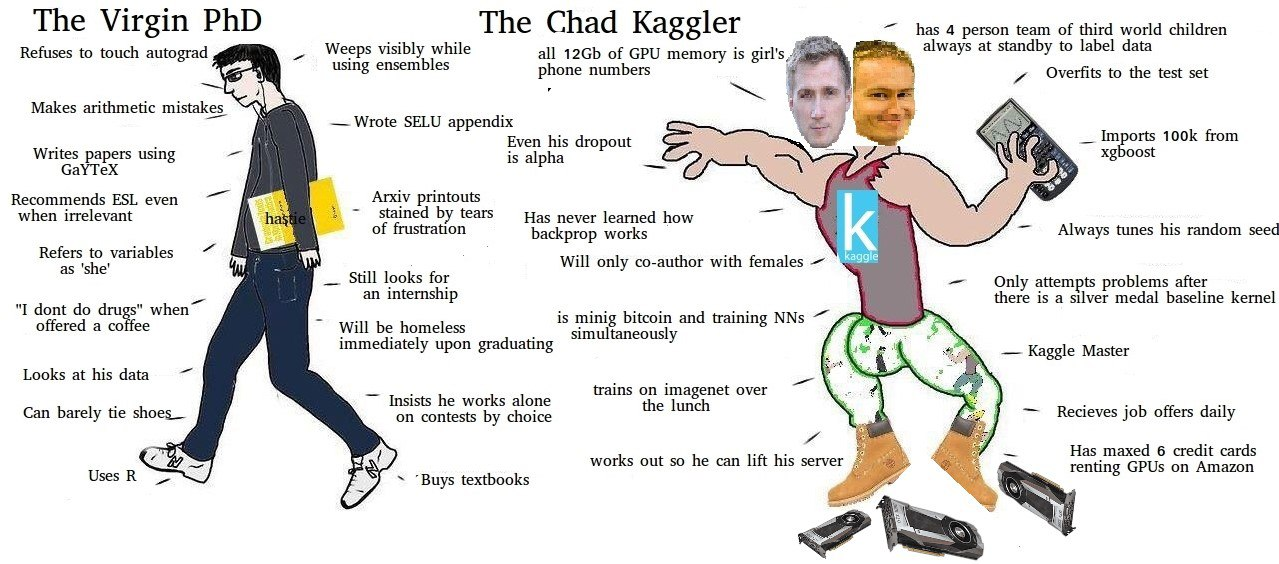

In [98]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Set
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Задание 1

С точки зрения NLP мне предстоит работать с задачей извлечения именованных сущностей (NER).Необходимо выделить из источника непрерывный фрагмент текста, который содержит сущность, под сущностью понимаются :
*   Личности - имееются в виду  фамилии и имена отдельный людей, например: “Donald Trump”
*   Местоположения - города , страны , регионы , деревни и т.п., например: "Москва"
*   Организации - названия любых объединений - политические партии, интернациональные союзы и т.п.,например:“NATO”
*   Мероприятия - концерты , конференции и т.п. , например:“​Katastrofa
Czernobylska”
*   Продукты - электроника ,оружие , книги и т.п.,например:“The New York Times”

Классические методы решения:
*   Основанные на правилах - используются регулярки , наборы шаблонов и словарей
*   Статистические методы - используются модели машинного обучения:SVM,HMM,CRF
*   Глубинное обучение - наиболее популярные архитектуры нейронных сетей :BERT,
RoBERTa,XLNet

Решение с помощью LLM подразумевает формирование промт запроса к модели ,LLM справляются с этой задачей хорошо ,а мы это проверим.
Основная метрика для нашей задачи – это  F-мера


Задание 2

Заполню колонку document_text с помощью текстов из raw папки , а gold_answer заполняю файлами из папки annotated, entity буду заполнять в ходе запросов к LLM

In [85]:
raw_folder = '/content/drive/MyDrive/SberDevises/raw'
annotated_folder = '/content/drive/MyDrive/SberDevises/anotated'
data = []
doc_id_counter = 1
raw_files = sorted([f for f in os.listdir(raw_folder)])
annotated_files = sorted([f for f in os.listdir(annotated_folder)])
for raw_file, annotated_file in zip(raw_files, annotated_files):
    with open(os.path.join(raw_folder, raw_file), 'r', encoding='utf-8') as f:
        content = f.read().split('\n')
        text = '\n'.join(content[4:]).strip()
    with open(os.path.join(annotated_folder, annotated_file), 'r', encoding='utf-8') as af:
        content = af.read().split('\n')
        annotations = '\n'.join(content[1:]).strip()
    data.append({
        'document_id': doc_id_counter,
        'document_text': text,
        'entity': None,
        'gold_answer': annotations
    })
    doc_id_counter += 1
df = pd.DataFrame(data, columns=['document_id', 'document_text', 'entity', 'gold_answer'])
df.head()

,document_id,document_text,entity,gold_answer
0,1,Тереза Мэй рассчитывает усидеть в седле до зав...,None,Brexit\tBrexit\tEVT\tEVT-Brexit\nАльбиона\tАль...
1,2,Стратегию Лондона на переговорах по «Брекситу»...,None,Brexit\tBrexit\tEVT\tEVT-Brexit\nБориса Джонсо...
2,3,Премьер под ударом: почему увольняются министр...,None,Bloomberg\tBloomberg\tORG\tORG-Bloomberg-LP\nB...
3,4,Британские министры уходят из-за «мягкого Brex...,None,Brexit\tBrexit\tEVT\tEVT-Brexit\nNigel Farage\...
4,5,Борис Джонсон объяснил причины своей отставки ...,None,Brexit\tBrexit\tEVT\tEVT-Brexit\nThe Sunday Te...


Задание 3

Написал функцию для генерации промт запросов

In [86]:
def generate_llm_prompt(row):
    base_prompt = """Проанализируй текст и извлеки все именованные сущности (NER).
Доступные типы сущностей:
PER - персона
LOC - локация
ORG - организация
EVT - событие
PRO - продукт
Если сущности нет в тексте , то не выделяй ее
Текст для анализа:
{text}
Извлеки сущности из приведенного текста"""
    return base_prompt.format(
        text=row['document_text']
    )

Задание 4

Теперь отправим запросы GigaСhat-у.Для этого использую написанную функцию на всех текстах из датафрейма



In [87]:
for i in range(len(df)):
  promt = generate_llm_prompt(df.iloc[i])
  print(promt)

Проанализируй текст и извлеки все именованные сущности (NER).
Доступные типы сущностей:
PER - персона
LOC - локация
ORG - организация
EVT - событие
PRO - продукт
Если сущности нет в тексте , то не выделяй ее
Текст для анализа:
Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit

Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зрения Джонсона, "Лондон обернул британскую конституцию поясом смертника и вручил детонатор Мишелю Барнье (главному переговорщику Брюсселя по "брекзиту". - От ред.)". С этой метафорой и предстоит сражаться на конференции главе правительства Альби

С помощью полученных промт запросов сформировал ответы от GigaChat , иногда приходилось делать дополнительный запрос т.к.текст не влазил в лимиты тг

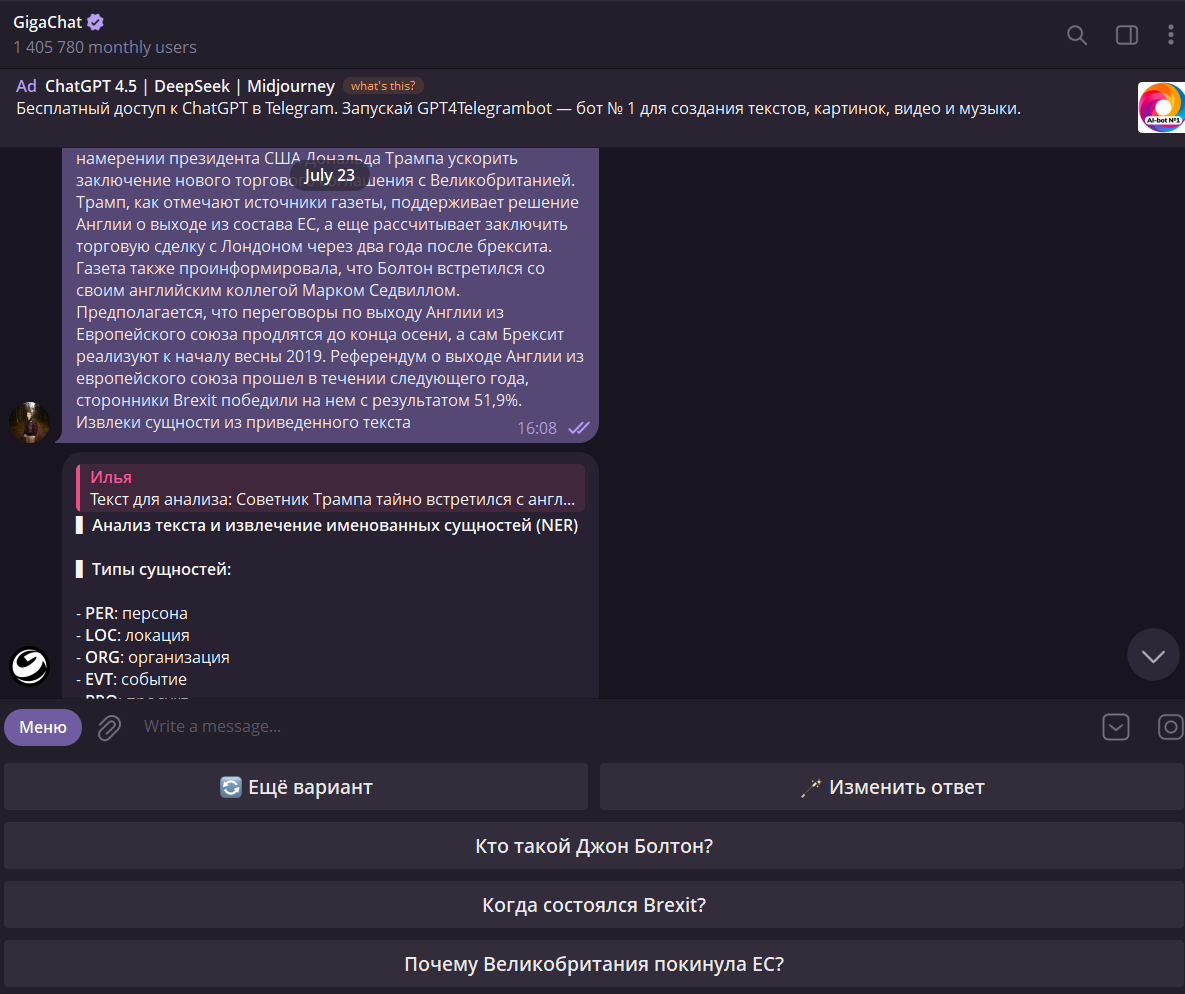

Полученные ответы от LLM добавлю в датафрейм.Сейчас будет полотно из добавленя ответов от LLM в датафрейм

In [88]:
df.loc[df.index[0], 'entity'] = '''Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Мишель Барнье	Мишель Барнье	PER	PER-Michel-Barnier
Себастьян Курц	Себастьян Курц	PER	PER-Sebastian-Kurz
Северная Ирландия	Северная Ирландия	LOC	GPE-Northern-Ireland
Альбион	Альбион	LOC	GPE-Albion
Лондон	Лондон	LOC	GPE-London
Великобритания	Великобритания	LOC	GPE-United-Kingdom
Британия	Британия	LOC	GPE-United-Kingdom
Европа	Европа	LOC	LOC-Europe
Брюссель	Брюссель	LOC	GPE-Brussels
Британские СМИ	Британские СМИ	ORG	ORG-UK-Media
Партия тори	Партия тори	ORG	ORG-Conservative-Party
Букмекеры	Букмекеры	ORG	ORG-Bookmakers
Международный валютный фонд	Международный валютный фонд	ORG	ORG-IMF
Европейский Союз	Европейский Союз	ORG	ORG-European-Union
ЕС	ЕС	ORG	ORG-European-Union
Консервативная партия	Консервативная партия	ORG	ORG-Conservative-Party
Еврокомиссия	Еврокомиссия	ORG	ORG-European-Commission
Европейский парламент	Европейский парламент	ORG	ORG-European-Parliament
Британский парламент	Британский парламент	ORG	ORG-UK-Parliament
Оппозиционные британские лейбористы	Оппозиционные британские лейбористы	ORG	ORG-UK-Labour-Party
Консерваторы	Консерваторы	ORG	ORG-Conservatives
Brexit	Brexit	EVT	EVT-Brexit
брекзит	брекзит	EVT	EVT-Brexit
Экстренный саммит Европейского Союза	Экстренный саммит Европейского Союза	EVT	EVT-EU-Emergency-Summit
Конференция Консервативной партии	Конференция Консервативной партии	EVT	EVT-Conservative-Party-Conference
Утверждение сделки с Евросоюзом в британском парламенте	Утверждение сделки с Евросоюзом в британском парламенте	EVT	EVT-UK-Parliament-EU-Deal-Approval
Пакет экстренных законов в области регулирования финансовых рынков	Пакет экстренных законов в области регулирования финансовых рынков	EVT	EVT-Financial-Markets-Emergency-Laws'''

In [89]:
df.loc[df.index[1], 'entity'] =  ''' Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Джереми Хант	Джереми Хант	PER	PER-Jeremy-Hunt
Лондон	Лондон	LOC	GPE-London
Великобритания	Великобритания	LOC	GPE-United-Kingdom
ЕС	ЕС	ORG	ORG-European-Union
Правительство Великобритании	Правительство Великобритании	ORG	ORG-UK-Government
РИА Новости	РИА Новости	ORG	ORG-RIA-News
Министерство иностранных дел	Министерство иностранных дел	ORG	ORG-UK-Foreign-Office
МИД	МИД	ORG	ORG-UK-Foreign-Office
Переговоры по «Брекситу»	Переговоры по Брекситу	EVT	EVT-Brexit-Negotiations
Выход Великобритании из ЕС	Выход Великобритании из ЕС	EVT	EVT-UK-EU-Exit
Официальная публикация стратегии по «Брекситу»	Официальная публикация стратегии по Брекситу	EVT	EVT-Brexit-Strategy-Publication
White Paper	White Paper	PRO	PRO-White-Paper
Документ-стратегия	Документ-стратегия	PRO	PRO-Strategy-Document'''

In [90]:
df.loc[df.index[2], 'entity'] = '''Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Ричард Саква	Ричард Саква	PER	PER-Richard-Sakwa
Джереми Корбин	Джереми Корбин	PER	PER-Jeremy-Corbyn
Сергей Скрипаль	Сергей Скрипаль	PER	PER-Sergei-Skripal
Юлия Скрипаль	Юлия Скрипаль	PER	PER-Yulia-Skripal
Доминик Рааб	Доминик Рааб	PER	PER-Dominic-Raab
Джеймс Шерр	Джеймс Шерр	PER	PER-James-Sherr
Елена Ананьева	Елена Ананьева	PER	PER-Elena-Ananieva
Константин Косачев	Константин Косачев	PER	PER-Konstantin-Kosachev
Чекерс	Чекерс	LOC	GPE-Checkers
Лондон	Лондон	LOC	GPE-London
Великобритания	Великобритания	LOC	GPE-United-Kingdom
ЕС	ЕС	ORG	ORG-European-Union
Москва	Москва	LOC	GPE-Moscow
Россия	Россия	LOC	GPE-Russia
Консервативная партия	Консервативная партия	ORG	ORG-Conservative-Party
Лейбористская партия	Лейбористская партия	ORG	ORG-Labour-Party
The Times	The Times	ORG	ORG-The-Times
YouGov	YouGov	ORG	ORG-YouGov
Chatham House	Chatham House	ORG	ORG-Chatham-House
Совет Федерации	Совет Федерации	ORG	ORG-Federation-Council
МИД Великобритании	МИД Великобритании	ORG	ORG-UK-Foreign-Office
Правительственная структура Великобритании	Правительственная структура Великобритании	ORG	ORG-UK-Government-Structure
ГРУ	ГРУ	ORG	ORG-GRU
Brexit	Brexit	EVT	EVT-Brexit
Отравление Сергея Скрипаля и Юлии Скрипаль	Отравление Скрипалей	EVT	EVT-Skripal-Poisoning
Вступление Бориса Джонсона в должность министра иностранных дел	Вступление Джонсона в должность	EVT	EVT-Johnson-Foreign-Secretary-Appointment
Визит Бориса Джонсона в Москву	Визит Джонсона в Москву	EVT	EVT-Johnson-Moscow-Visit
Выборы премьер-министра Великобритании	Выборы премьер-министра	EVT	EVT-UK-Prime-Minister-Election
Реакция Великобритании на инцидент с отравлением Скрипалей	Реакция на отравление Скрипалей	EVT	EVT-UK-Response-Skripal
Прием британской версии закона Магнитского	Прием закона Магнитского	EVT	EVT-UK-Magnitsky-Act
Закон Магнитского	Закон Магнитского	PRO	PRO-Magnitsky-Act
Novichok	Novichok	PRO	PRO-Novichok
Нервно-паралитическое вещество	Нервно-паралитическое вещество	PRO	PRO-Nerve-Agent '''

In [91]:
df.loc[df.index[3], 'entity'] = '''Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Дэвид Дэвис	Дэвид Дэвис	PER	PER-David-Davis
Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Найджел Фарадж	Найджел Фарадж	PER	PER-Nigel-Farage
Дональд Туск	Дональд Туск	PER	PER-Donald-Tusk
Великобритания	Великобритания	LOC	GPE-United-Kingdom
Соединённое Королевство	Соединённое Королевство	LOC	GPE-United-Kingdom
ЕС	ЕС	ORG	ORG-European-Union
Евросоюз	Евросоюз	ORG	ORG-European-Union
Консервативная партия	Консервативная партия	ORG	ORG-Conservative-Party
Парламент Великобритании	Парламент Великобритании	ORG	ORG-UK-Parliament
Европейский совет	Европейский совет	ORG	ORG-European-Council
Brexit	Brexit	EVT	EVT-Brexit
Отставка министров	Отставка министров	EVT	EVT-Ministers-Resignation
Заседание парламента	Заседание парламента	EVT	EVT-Parliament-Session
Референдум о выходе из ЕС	Референдум о выходе из ЕС	EVT	EVT-EU-Referendum
Потеря доверия лидером партии	Потеря доверия лидером партии	EVT	EVT-Leader-No-Confidence '''

In [92]:
df.loc[df.index[4], 'entity'] = ''' Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Адольф Гитлер	Адольф Гитлер	PER	PER-Adolf-Hitler
Наполеон	Наполеон	PER	PER-Napoleon
Великобритания	Великобритания	LOC	GPE-Great-Britain
ЕС	ЕС	ORG	ORG-European-Union
Евросоюз	Евросоюз	ORG	ORG-European-Union
Кабинет министров Великобритании	Кабинет министров Великобритании	ORG	ORG-UK-Cabinet
МИД Великобритании	МИД Великобритании	ORG	ORG-UK-Foreign-Office
Brexit	Brexit	EVT	EVT-Brexit
Отставка Бориса Джонсона	Отставка Бориса Джонсона	EVT	EVT-Boris-Johnson-Resignation
Согласование позиции кабинета министров	Согласование позиции кабинета министров	EVT	EVT-UK-Cabinet-Position
Создание зоны свободной торговли с ЕС	Создание зоны свободной торговли с ЕС	EVT	EVT-EU-Free-Trade-Zone
Референдум по Brexit	Референдум по Brexit	EVT	EVT-Brexit-Referendum  '''

In [93]:
df.loc[df.index[5], 'entity'] = '''Борис Джонсон	Борис Джонсон	PER	PER-Boris-Johnson
Джереми Хант	Джереми Хант	PER	PER-Jeremy-Hunt
Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Великобритания	Великобритания	LOC	GPE-Great-Britain
МИД Великобритании	МИД Великобритании	ORG	ORG-UK-Foreign-Office
Канцелярия премьер-министра Британии	Канцелярия премьер-министра Британии	ORG	ORG-UK-Prime-Ministers-Office
Twitter	Twitter	ORG	ORG-Twitter
Government	Government	ORG	ORG-UK-Government
EU	EU	ORG	ORG-European-Union
Brexit	Brexit	EVT	EVT-Brexit
Назначение Джереми Ханта новым главой МИД	Назначение Джереми Ханта новым главой МИД	EVT	EVT-Jeremy-Hunt-Foreign-Secretary-Appointment
Отставка Бориса Джонсона	Отставка Бориса Джонсона	EVT	EVT-Boris-Johnson-Resignation
Разногласия правительства по Brexit	Разногласия правительства по Brexit	EVT	EVT-UK-Government-Brexit-Disagreements  '''

In [94]:
df.loc[df.index[6], 'entity'] = '''Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Ангела Меркель	Ангела Меркель	PER	PER-Angela-Merkel
Дональд Туск	Дональд Туск	PER	PER-Donald-Tusk
Мишель Барнье	Мишель Барнье	PER	PER-Michel-Barnier
Англия	Англия	LOC	GPE-England
ЕС	ЕС	ORG	ORG-European-Union
Северная Ирландия	Северная Ирландия	LOC	GPE-Northern-Ireland
Ирландия	Ирландия	LOC	GPE-Ireland
Зальцбург	Зальцбург	LOC	GPE-Salzburg
Консервативная партия	Консервативная партия	ORG	ORG-Conservative-Party
Reuters	Reuters	ORG	ORG-Reuters
ЕС	ЕС	ORG	ORG-European-Union
Brexit	Brexit	EVT	EVT-Brexit
Саммит ЕС	Саммит ЕС	EVT	EVT-EU-Summit
Переговоры о выходе Великобритании из ЕС	Переговоры о выходе Великобритании из ЕС	EVT	EVT-UK-EU-Exit-Negotiations
Конференция Консервативной партии	Конференция Консервативной партии	EVT	EVT-Conservative-Party-Conference
Фунт стерлингов	Фунт стерлингов	PRO	PRO-Pound-Sterling '''

In [95]:
df.loc[df.index[7], 'entity'] =  '''Джон Болтон	Джон Болтон	PER	PER-John-Bolton
Дональд Трамп	Дональд Трамп	PER	PER-Donald-Trump
Марк Седвилл	Марк Седвилл	PER	PER-Mark-Sedwill
Тереза Мэй	Тереза Мэй	PER	PER-Theresa-May
Англия	Англия	LOC	GPE-England
США	США	LOC	GPE-United-States
ЕС	ЕС	ORG	ORG-European-Union
Лондон	Лондон	LOC	GPE-London
Консервативная партия	Консервативная партия	ORG	ORG-Conservative-Party
Европейская исследовательская группа	Европейская исследовательская группа	ORG	ORG-European-Research-Group
The Telegraph	The Telegraph	ORG	ORG-The-Telegraph
The Sunday Telegraph	The Sunday Telegraph	ORG	ORG-The-Sunday-Telegraph
Тайная встреча Джона Болтона с евроскептиками	Тайная встреча Джона Болтона с евроскептиками	EVT	EVT-John-Bolton-Euroskeptics-Meeting
Переговоры по выходу Англии из ЕС	Переговоры по выходу Англии из ЕС	EVT	EVT-UK-EU-Exit-Negotiations
Посещение Дональдом Трампом Лондона	Посещение Дональдом Трампом Лондона	EVT	EVT-Donald-Trump-London-Visit
Brexit	Brexit	EVT	EVT-Brexit-Formal-Withdrawal '''

In [96]:
df.loc[df.index[8], 'entity'] =  '''Джон Болтон       Джон Болтон       PER  PER-John-Bolton
Дональд Трамп     Дональд Трамп     PER  PER-Donald-Trump
Марк Седвилл      Марк Седвилл      PER  PER-Mark-Sedwill
Англия            Англия            LOC  GPE-England
США               США               LOC  GPE-United-States
ЕС                ЕС                ORG  ORG-European-Union
Европейская исследовательская группа  Европейская исследовательская группа  ORG  ORG-European-Research-Group
The Telegraph      The Telegraph      ORG  ORG-The-Telegraph
Brexit (референдум о выходе Англии из ЕС)  Brexit  EVT  EVT-Brexit-Referendum
Встреча Джона Болтона с евроскептиками     Встреча Джона Болтона с евроскептиками  EVT  EVT-Bolton-Eurosceptics-Meeting
Проведение референдума о Brexit            Проведение референдума о Brexit  EVT  EVT-Brexit-Referendum-Holding
Переговоры по выходу Англии из ЕС          Переговоры по выходу Англии из ЕС  EVT  EVT-UK-EU-Exit-Negotiations '''

Посмотрим на получившийся df

In [97]:
df.head()

,document_id,document_text,entity,gold_answer
0,1,Тереза Мэй рассчитывает усидеть в седле до зав...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\n...,Brexit\tBrexit\tEVT\tEVT-Brexit\nАльбиона\tАль...
1,2,Стратегию Лондона на переговорах по «Брекситу»...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\...,Brexit\tBrexit\tEVT\tEVT-Brexit\nБориса Джонсо...
2,3,Премьер под ударом: почему увольняются министр...,Борис Джонсон\tБорис Джонсон\tPER\tPER-Boris-J...,Bloomberg\tBloomberg\tORG\tORG-Bloomberg-LP\nB...
3,4,Британские министры уходят из-за «мягкого Brex...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\n...,Brexit\tBrexit\tEVT\tEVT-Brexit\nNigel Farage\...
4,5,Борис Джонсон объяснил причины своей отставки ...,Борис Джонсон\tБорис Джонсон\tPER\tPER-Boris-...,Brexit\tBrexit\tEVT\tEVT-Brexit\nThe Sunday Te...


И сохраню его


In [99]:
df.to_csv('Sber.csv', index=False, encoding='utf-8-sig')
files.download('Sber.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Задание 5

Соответсвенно я выбрал метрику F1 т.к. именно эта метрика позволяет находить баланс между pr и rc , я считаю , что в задаче по извличению сущностей это крайне важно т.к. нас явно не устраивает ситуация в которой модель извлекает все подряд и называет это например продуктом(будет высокий recall) и не устраивает находить лишь одну сущность из множества других (высокий precision).Насколько мне известно F1 довольно популярный выбор для задачи NER.

Решение можно было бы ускорить через векторизацию т.к. при работе с реально большим датафреймом это позволило бы оптимизировать работу т.к. позволило бы использовать операции pandas(они заточены под работу с большими данными), да и работать с векторами намного приятнеее и удобнее чем со строками.

По поводу юни тестов , то я в них не умею ,но я способный и всегда готов к изучению нового.

In [100]:
def preprocess_entities(entities_str: str) -> Set[str]:# Нормализую сущности для удобства работы
    if pd.isna(entities_str) or not entities_str.strip():
        return set()
    lines = [line.split('\t') for line in entities_str.strip().split('\n')]
    normalized_entities = {line[3].strip() for line in lines if len(line) >= 4}
    return normalized_entities
def score_fn(gold: str, pred: str) -> float:
    gold_entities = preprocess_entities(gold)
    pred_entities = preprocess_entities(pred)
    if not gold_entities and not pred_entities:
        return 1.0
    if not gold_entities or not pred_entities:
        return 0.0
    true_positives = len(gold_entities & pred_entities)
    false_positives = len(pred_entities - gold_entities)
    false_negatives = len(gold_entities - pred_entities)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

Задание 6

Посчитал метрику по документам и по сущностям

In [101]:
df['f1_score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['entity']), axis=1)
all_entities = set()
for ents in df['gold_answer'].dropna().apply(preprocess_entities):
    all_entities.update(ents)
for ents in df['entity'].dropna().apply(preprocess_entities):
    all_entities.update(ents)
entity_results = []
for entity in all_entities:
    gold_counts = df['gold_answer'].apply(lambda x: entity in preprocess_entities(x)).sum()
    pred_counts = df['entity'].apply(lambda x: entity in preprocess_entities(x)).sum()
    tp = df.apply(lambda row: (entity in preprocess_entities(row['gold_answer'])) and
                           (entity in preprocess_entities(row['entity'])), axis=1).sum()
    precision = tp / pred_counts if pred_counts > 0 else 0
    recall = tp / gold_counts if gold_counts > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    entity_results.append({
        'entity': entity,
        'f1': f1
    })
entity_stats = pd.DataFrame(entity_results)

Здесь можем увидеть метрику по документам

In [102]:
df

,document_id,document_text,entity,gold_answer,f1_score
0,1,Тереза Мэй рассчитывает усидеть в седле до зав...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\n...,Brexit\tBrexit\tEVT\tEVT-Brexit\nАльбиона\tАль...,0.465116
1,2,Стратегию Лондона на переговорах по «Брекситу»...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\...,Brexit\tBrexit\tEVT\tEVT-Brexit\nБориса Джонсо...,0.400000
2,3,Премьер под ударом: почему увольняются министр...,Борис Джонсон\tБорис Джонсон\tPER\tPER-Boris-J...,Bloomberg\tBloomberg\tORG\tORG-Bloomberg-LP\nB...,0.435897
3,4,Британские министры уходят из-за «мягкого Brex...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\n...,Brexit\tBrexit\tEVT\tEVT-Brexit\nNigel Farage\...,0.470588
4,5,Борис Джонсон объяснил причины своей отставки ...,Борис Джонсон\tБорис Джонсон\tPER\tPER-Boris-...,Brexit\tBrexit\tEVT\tEVT-Brexit\nThe Sunday Te...,0.560000
5,6,"Стало известно, кто сменил Бориса Джонсона на ...",Борис Джонсон\tБорис Джонсон\tPER\tPER-Boris-J...,Brexit (Брексит)\tBrexit (Брексит)\tEVT\tEVT-B...,0.500000
6,7,Переговоры о выходе Англии из ЕС зашли в тупик...,Тереза Мэй\tТереза Мэй\tPER\tPER-Theresa-May\n...,Brexit\tBrexit\tEVT\tEVT-Brexit\nReuters\tReut...,0.666667
7,8,В Англии прошла тайная встреча советника Трамп...,Джон Болтон\tДжон Болтон\tPER\tPER-John-Bolton...,Brexit\tBrexit\tEVT\tEVT-Brexit\nThe Sunday Te...,0.466667
8,9,Советник Трампа тайно встретился с английскими...,Джон Болтон Джон Болтон PER PER-J...,Brexit\tBrexit\tEVT\tEVT-Brexit\nThe Telegraph...,0.000000


Здесь метрика по сущностям

In [103]:
entity_stats

,entity,f1
0,GPE-London,0.666667
1,PRO-The-Times,0.000000
2,PER-Napoleon-Bonaparte,0.000000
3,PER-Konstantin-Kosachev,1.000000
4,ORG-Scottish-National-Party,0.000000
...,...,...
132,EVT-Johnson-Foreign-Secretary-Appointment,0.000000
133,ORG-UK-Cabinet,0.000000
134,ORG-Labour-Party-UK,0.000000
135,PER-Donald-Trump,0.666667


Теперь визуализирую распределение F1 метрики по сущностям и документам

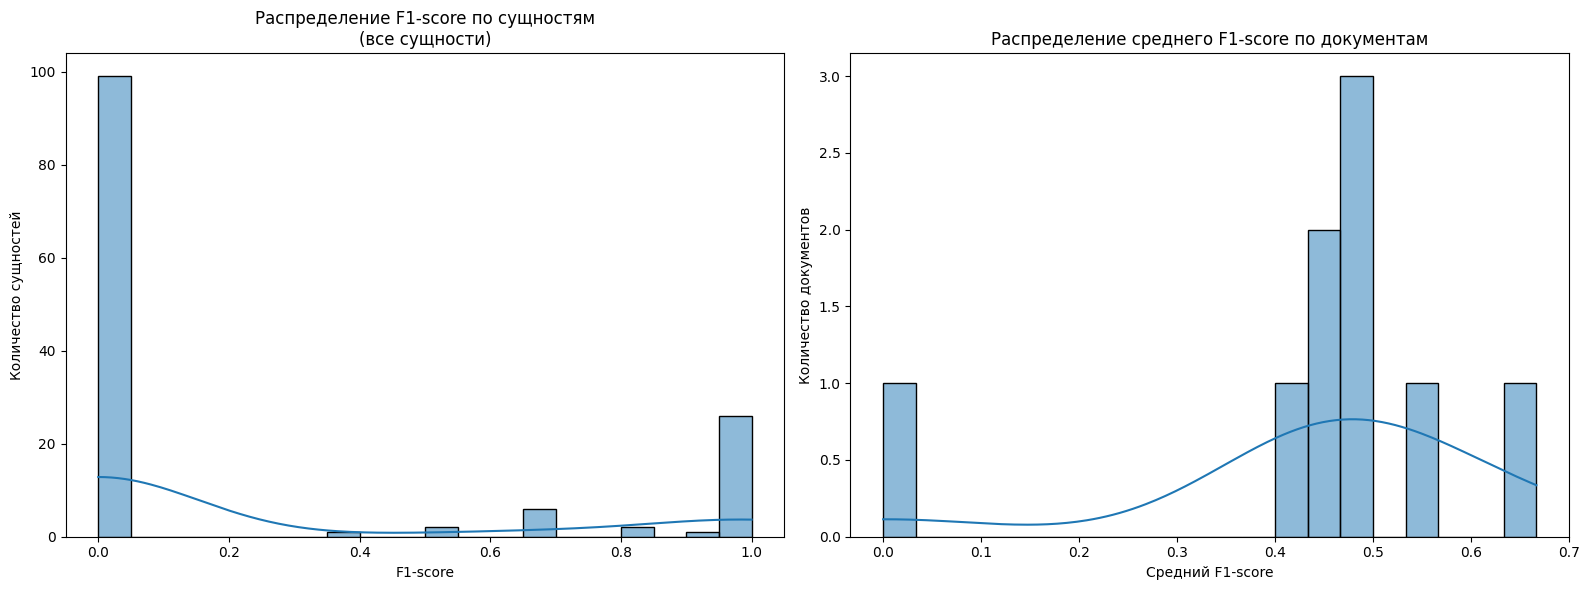

In [104]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=entity_stats, x='f1', bins=20, kde=True)
plt.title('Распределение F1-score по сущностям\n(все сущности)')
plt.xlabel('F1-score')
plt.ylabel('Количество сущностей')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='f1_score', bins=20, kde=True)
plt.title('Распределение среднего F1-score по документам')
plt.xlabel('Средний F1-score')
plt.ylabel('Количество документов')
plt.tight_layout()

plt.show()

По сущностям:

Подавляющие большинство сущyностей имеют F1 равный нулю , а значит моделька плохо справляется с детекцией этих сущностей, при этом можно увидеться концентрацию объектов с F1 = 1 , что говорит о том , что моделька отлично справляется с некоторым множеством объектов

По документам:

Большинство документов имеет скор в районе 0,45  , что говорит о том , что моделька средненько справляется с поставленной задачей , интересно было бы посмотреть на документ с F1 = 0 , но поскольку он один , то могу списать на свою ошибку

Вывод:

Средний F1 по документам находится в районе 0.45 , что говорит о том , что модель с поставленной задачей справляется не очень хорошо , но и неплохо.

Задание 7

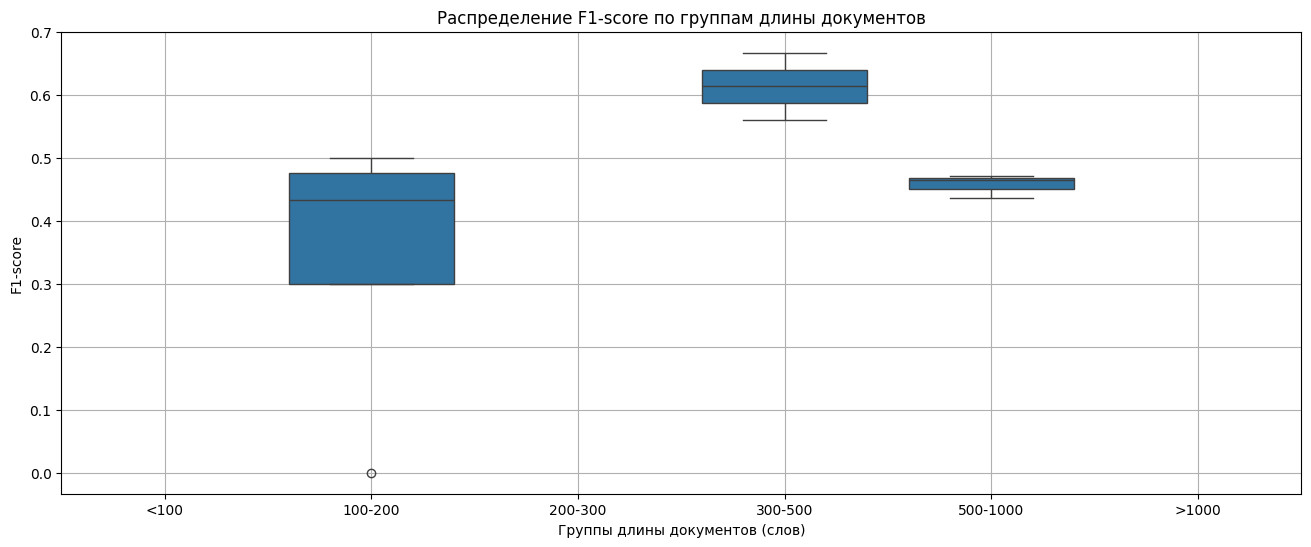

In [105]:
df['doc_length'] = df['document_text'].apply(lambda x: len(x.split()))
doc_metrics = df.groupby('document_id').agg({
    'f1_score': 'mean',
    'doc_length': 'first'
}).reset_index()

doc_metrics['length_group'] = pd.cut(doc_metrics['doc_length'],
                                   bins=[0, 100, 200, 300, 500, 1000, float('inf')],
                                   labels=['<100', '100-200', '200-300', '300-500', '500-1000', '>1000'])

plt.figure(figsize=(16, 6))


sns.boxplot(data=doc_metrics, x='length_group', y='f1_score', order=['<100', '100-200', '200-300', '300-500', '500-1000', '>1000'])
plt.title('Распределение F1-score по группам длины документов')
plt.xlabel('Группы длины документов (слов)')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()

Зависимость от длины текста точно есть. Модель лучше всего себя показала на текстах с длинной  300-500 слов , для более длинных или коротких текстов видно заметное падение качества

Задание 8

Итак модель показывает наилучшее качество на текста длинной 300-500 слов , для моего датафрейма будем считать это средней длинной . Как мне кажется такой результат вполне логичен и объясним . В более длинных текстах намного больше сущностей -> легче ошибиться -> выше ошибка , думаю , что на более длинных текстах у модели возникают проблемы с поддрежанием контекста, в более коротких текстах модели может не хватать контекста и она просто не успевает обучиться под них. Соответсвенно можно сказать , что LLM лучше всего справляется с текстами средней длины , при этом большинство сущностей имеют F1 ранвый 0 , то есть вообще не вносят изменений на F1 ,возможно это связано с тем как я нормализовал сущности , мб что-то испортил. Если подводить итог по модели в целом , то средний F1 = 0.45 я считаю приемлемым результатом для LLM , все таки она не была обучена напрямую справляться с задачей NER. Для повышения метрик  я бы посоветовал :

1.   Добавить данные для обучения моделей - очевидно , что в датасете было больше текстов средней длинны и модельке нужно показать больше длинных и коротких текстов
2.   Возможно поработать над длинной контекста чтобы моделька лучше справлялась с длинными текстами
3.   Больше времени уделить предобработке сущностей поработать над их нормализацией





Задание 9

Выводы:

1.   GigaChat - неплохо српавляется с задачей NER , mean F1 = 0.45 ,что крайне неплохо как для модели не обученной для решений этой задачи
2.   Большинство сущностей прошли мимо модельки , что может быть вызвано как подходом к нормализации так и просто тем , что модель с большинством сущностей справляется плохо
3.   Длина - важно , модель лучше всего справилась с текстами средней длинны, их было больше в датафрейме
4.   Необходимо добавить больше семплов как и коротких текстов так и длинных

В ходе выполненния исследования я :

1.   Углубил свои знания в сфере NLP , а именно NER , прочитал несколько статей по теме извличения сущностей , узнал про различные способы решения этой задачи , попробовал сам ее
2.   Поработал с LLM как с помошником для исследования и узнал , что она неплохо справляется с задачей NER
3.   Добавил к себе в гитхаб еще один проект
4.   Набил руку в работе с текстами с точки зрения их обработки на python
